# Corridor Travel Times

### Define 2 comparison scenario locations

In [136]:
scen1_loc = r'U:\brice\sc_2040demand_2014net'
scen2_loc = r'S:\Stefan\soundcast_10peak_5offpeak'

current_run_name = 'soundcast_2014'
scen1_name = '2040 No Build'
scen2_name = '2040 10/5 Toll'

# Set comparison scenario:
compare_scen = scen2_name

In [2]:
import os
import pandas as pd
import h5py
%matplotlib inline

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# O-D SOV Travel Times

In [4]:
# Load observed data (2013 currently)
od_obs = pd.read_csv(r'..\..\..\scripts\summarize\inputs\network_summary\od_travel_times.csv')

In [5]:
user_class = 'svtl1t'
max_internal_zone = 3700
zone_list = [532,2286,1552,1125]

run_dict = {'run': current_run_name,
            scen1_loc: scen1_name,
           scen2_loc: scen2_name}

# Need zone terminal times to compare to observed
o_tt = pd.read_csv(r'..\..\..\inputs\IntraZonals\origin_tt.in',
                   sep=' ',header=4)


o_tt.index = o_tt.index.get_level_values(1)
o_tt['taz'] = o_tt.index
o_tt['terminal_time'] = o_tt['matrix=mo"prodtt"']
o_tt = pd.DataFrame(o_tt[['terminal_time','taz']])

results_dict = {}

for skim_name in ['7to8','17to18']:
    user_class_dict = {}
    for user_class in ['svtl2t','h3tl2t']:
        results = pd.DataFrame()

        for run_dir, current_run_name in run_dict.iteritems():
            skims_dir = run_dir + r'\inputs'

            if run_dir == 'run':
                h5_contents = h5py.File(r'..\..\..\inputs' + r'\\' + skim_name + '.h5')
            else:
                h5_contents = h5py.File(skims_dir + r'\\' + skim_name + '.h5')
            for zone in zone_list:
                df = pd.DataFrame()
                df[user_class] = h5_contents['Skims'][user_class][:][zone-1,:max_internal_zone]
                df['otaz'] = zone
                df['dtaz'] = df.index+1
                df['travel_time'] = df[user_class]/100 # skim data is stored in hundreds

                df = df[df['dtaz'].isin(zone_list)]

        #      Subtract the terminal times
                df = pd.merge(df,o_tt,left_on='dtaz',right_on='taz')
                # Subtract destination terminal time
                df['travel_time'] = df['travel_time']-df['terminal_time']
                # Subtract origin terminal time
                df['travel_time'] = df['travel_time']-(o_tt[o_tt['taz'] == zone]['terminal_time'].values[0])

                df['source'] = current_run_name
                results = results.append(df)

        user_class_dict[user_class] = results
    results_dict[skim_name] = user_class_dict

# Auto Travel Times

In [11]:
results_df = {}
for time, results in results_dict['7to8'].iteritems():
    scen1 = results[results['source'] == current_run_name][['travel_time','otaz','dtaz']]
    scen2 = results[results['source'] == scen1_name][['travel_time','otaz','dtaz']]
    scen3 = results[results['source'] == scen2_name][['travel_time','otaz','dtaz']]

    df = pd.merge(scen1, scen2, on=['otaz','dtaz'], suffixes=["_"+current_run_name,"_"+scen1_name])

    df = pd.merge(df, scen3, on=['otaz','dtaz'], suffixes=["_"+current_run_name,"_"+scen2_name])
    df.rename(columns={'travel_time':'travel_time_'+scen2_name}, inplace=True)

    df.rename(columns={'travel_time_'+scen1_name:scen1_name,
                      'travel_time_'+scen2_name:scen2_name,
                      'travel_time_'+current_run_name:current_run_name}, inplace=True)

    df = pd.merge(df, od_obs[['otaz','dtaz','description','time_cong','time']], on=['otaz','dtaz'])
    df.index = df['description']
    df.rename(columns={'time_cong':'observed'},inplace=True)
    results_df[time] = df

## AM SOV

In [14]:
df = results_df['svtl2t']
df[['description',current_run_name,scen1_name,scen2_name,'observed']]

,description,soundcast_2014,2040 No Build,2040 10/5 Toll,observed
description,,,,,
Seattle-Federal Way,Seattle-Federal Way,31.59,34.25,30.89,32.0
Seattle-Bellevue,Seattle-Bellevue,23.10,25.87,22.10,28.0
Seattle-Everett,Seattle-Everett,45.56,51.55,41.28,39.0
Everett-Seattle,Everett-Seattle,67.25,85.17,59.17,50.0
Bellevue-Seattle,Bellevue-Seattle,27.10,30.74,24.64,26.0
Federal Way-Seattle,Federal Way-Seattle,49.72,70.27,48.61,49.0


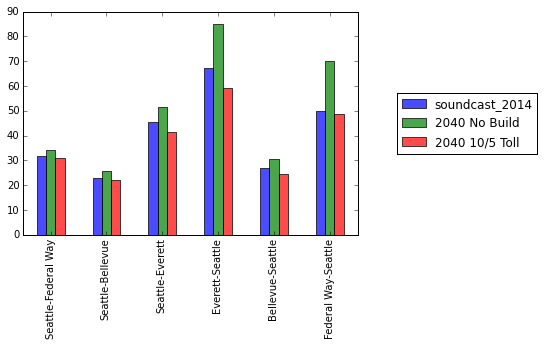

In [15]:
ax = df[[current_run_name,scen1_name,scen2_name]].plot(kind='bar', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel("")

## AM HOV

In [19]:
df = results_df['h3tl2t']
df[['description',current_run_name,scen1_name,scen2_name,'observed']]

,description,soundcast_2014,2040 No Build,2040 10/5 Toll,observed
description,,,,,
Seattle-Federal Way,Seattle-Federal Way,28.31,29.11,30.75,32.0
Seattle-Bellevue,Seattle-Bellevue,21.74,24.65,20.01,28.0
Seattle-Everett,Seattle-Everett,38.52,41.59,41.28,39.0
Everett-Seattle,Everett-Seattle,50.44,60.61,55.33,50.0
Bellevue-Seattle,Bellevue-Seattle,20.19,21.87,17.46,26.0
Federal Way-Seattle,Federal Way-Seattle,42.85,59.08,48.17,49.0


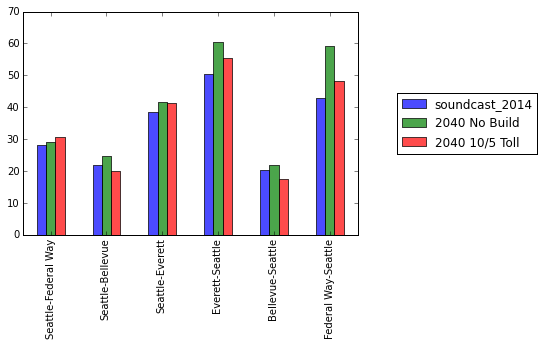

In [20]:
ax = df[[current_run_name,scen1_name,scen2_name]].plot(kind='bar', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel("")

# PM

In [22]:
results_df = {}
for time, results in results_dict['17to18'].iteritems():
    scen1 = results[results['source'] == current_run_name][['travel_time','otaz','dtaz']]
    scen2 = results[results['source'] == scen1_name][['travel_time','otaz','dtaz']]
    scen3 = results[results['source'] == scen2_name][['travel_time','otaz','dtaz']]

    df = pd.merge(scen1, scen2, on=['otaz','dtaz'], suffixes=["_"+current_run_name,"_"+scen1_name])

    df = pd.merge(df, scen3, on=['otaz','dtaz'], suffixes=["_"+current_run_name,"_"+scen2_name])
    df.rename(columns={'travel_time':'travel_time_'+scen2_name}, inplace=True)

    df.rename(columns={'travel_time_'+scen1_name:scen1_name,
                      'travel_time_'+scen2_name:scen2_name,
                      'travel_time_'+current_run_name:current_run_name}, inplace=True)

    df = pd.merge(df, od_obs[['otaz','dtaz','description','time_cong','time']], on=['otaz','dtaz'])
    df.index = df['description']
    df.rename(columns={'time_cong':'observed'},inplace=True)
    results_df[time] = df

# PM SOV

In [23]:
df = results_df['svtl2t']
df[['description',current_run_name,scen1_name,scen2_name,'observed']]

,description,soundcast_2014,2040 No Build,2040 10/5 Toll,observed
description,,,,,
Seattle-Federal Way,Seattle-Federal Way,47.01,64.91,46.24,32.0
Seattle-Bellevue,Seattle-Bellevue,27.57,31.20,26.42,28.0
Seattle-Everett,Seattle-Everett,67.21,86.08,61.08,39.0
Everett-Seattle,Everett-Seattle,50.16,58.04,45.23,50.0
Bellevue-Seattle,Bellevue-Seattle,24.90,29.73,23.45,26.0
Federal Way-Seattle,Federal Way-Seattle,33.80,36.93,32.11,49.0


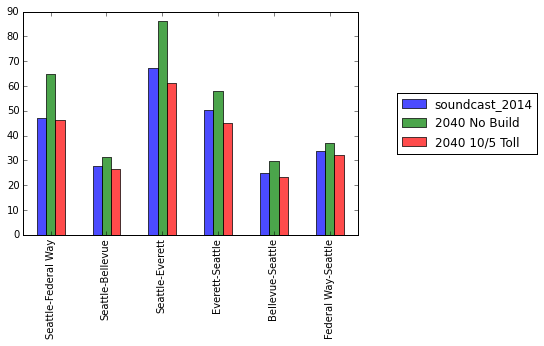

In [24]:
ax = df[[current_run_name,scen1_name,scen2_name]].plot(kind='bar', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel("")

## PM HOV

In [25]:
df = results_df['h3tl2t']
df[['description',current_run_name,scen1_name,scen2_name,'observed']]

,description,soundcast_2014,2040 No Build,2040 10/5 Toll,observed
description,,,,,
Seattle-Federal Way,Seattle-Federal Way,42.62,58.40,46.01,32.0
Seattle-Bellevue,Seattle-Bellevue,20.44,22.65,18.29,28.0
Seattle-Everett,Seattle-Everett,56.17,69.82,57.19,39.0
Everett-Seattle,Everett-Seattle,44.36,48.83,45.23,50.0
Bellevue-Seattle,Bellevue-Seattle,23.66,27.91,21.58,26.0
Federal Way-Seattle,Federal Way-Seattle,31.82,33.08,31.79,49.0


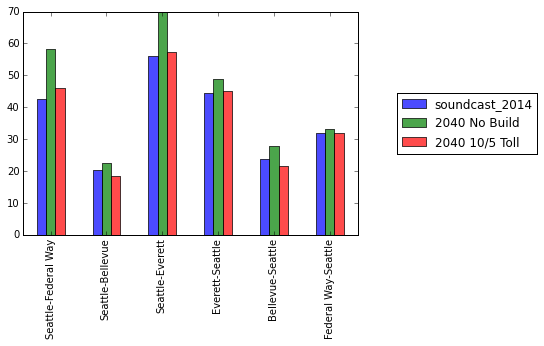

In [26]:
ax = df[[current_run_name,scen1_name,scen2_name]].plot(kind='bar', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel("")

# Transit Travel Times

In [195]:
max_internal_zone = 3700
zone_list = [532,2286,1552,1125]

run_dict = {'run': current_run_name,
            scen1_loc: scen1_name,
           scen2_loc: scen2_name}

results_dict = {}

for skim_name in ['7to8','17to18']:
    user_class_dict = {}
    for user_class in ['ivtwa','ivtwr']:
        results = pd.DataFrame()

        for run_dir, current_run_name in run_dict.iteritems():
            skims_dir = run_dir + r'\inputs'

            if run_dir == 'run':
                h5_contents = h5py.File(r'..\..\..\inputs' + r'\\' + skim_name + '.h5')
            else:
                h5_contents = h5py.File(skims_dir + r'\\' + skim_name + '.h5')
            for zone in zone_list:
                df = pd.DataFrame()
                
                df[user_class] = h5_contents['Skims'][user_class][:][zone-1,:max_internal_zone]
                df['otaz'] = zone
                df['dtaz'] = df.index+1
                df['travel_time'] = df[user_class]/100 # skim data is stored in hundreds

                df = df[df['dtaz'].isin(zone_list)]

                df['source'] = current_run_name
                results = results.append(df)
            
        user_class_dict[user_class] = results
    results_dict[skim_name] = user_class_dict

## AM Transit Times

In [200]:
skim_name = '7to8'

df_all = results_dict[skim_name]['ivtwa']
df_all['mode'] = 'ivtwa'
df_rail = results_dict[skim_name]['ivtwr']
df_rail['mode'] = 'ivtwr'
df = pd.merge(df_all,df_rail,on=['otaz','dtaz','source'], suffixes=['_all','_rail'])

df_all = results_dict[skim_name]['ivtwa']
df_all['mode'] = 'ivtwa'
df_rail = results_dict[skim_name]['ivtwr']
df_rail['mode'] = 'ivtwr'
df = pd.merge(df_all,df_rail,on=['otaz','dtaz','source'], suffixes=['_all','_rail'])

# Take minimum travel time 
df['travel_time_min'] = df[['travel_time_all','travel_time_rail']].min(axis=1)

# Separate results by scenario
run_df = df[df['source'] == current_run_name]
scen1 = df[df['source'] == scen1_name]
scen2 = df[df['source'] == scen2_name]

# Reformat output for scenarios 1 and 2 stacked
df = pd.merge(scen1,scen2,on=['otaz','dtaz'],suffixes=['_'+scen1_name,'_'+scen2_name])
df.rename(columns={'travel_time_min_'+scen1_name:scen1_name,'travel_time_min_'+scen2_name:scen2_name},inplace=True)
df = df[['otaz','dtaz',scen1_name,scen2_name]]

# add base scenario column
df = pd.merge(df,run_df,on=['otaz','dtaz'])
df.rename(columns={'travel_time_min':current_run_name},inplace=True)
df = df[['otaz','dtaz',current_run_name, scen1_name, scen2_name]]

# join observed data to get description
df = pd.merge(df, od_obs[['otaz','dtaz','description']], on=['otaz','dtaz'])
df.index = df.description
df= df.drop('description', axis=1)

## AM Travel Times

In [201]:
df

,otaz,dtaz,soundcast_2014,2040 No Build,2040 10/5 Toll
description,,,,,
Seattle-Federal Way,532,1125,28.60,29.20,35.12
Seattle-Bellevue,532,1552,33.77,36.02,24.00
Seattle-Everett,532,2286,49.85,52.69,61.00
Everett-Seattle,2286,532,60.40,70.65,61.00
Bellevue-Seattle,1552,532,25.97,26.55,22.00
Federal Way-Seattle,1125,532,41.80,49.84,49.82


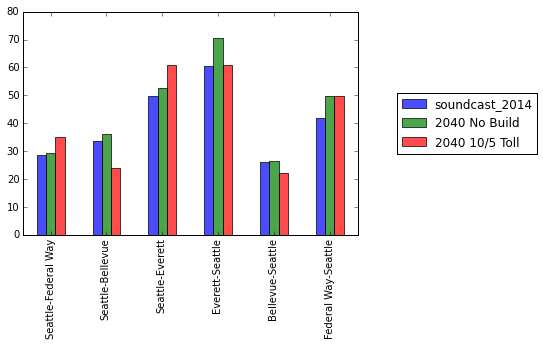

In [202]:
ax = df[[current_run_name,scen1_name,scen2_name]].plot(kind='bar', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel("")

## PM Transit Travel Times

In [204]:
skim_name = '17to18'

df_all = results_dict[skim_name]['ivtwa']
df_all['mode'] = 'ivtwa'
df_rail = results_dict[skim_name]['ivtwr']
df_rail['mode'] = 'ivtwr'
df = pd.merge(df_all,df_rail,on=['otaz','dtaz','source'], suffixes=['_all','_rail'])

df_all = results_dict[skim_name]['ivtwa']
df_all['mode'] = 'ivtwa'
df_rail = results_dict[skim_name]['ivtwr']
df_rail['mode'] = 'ivtwr'
df = pd.merge(df_all,df_rail,on=['otaz','dtaz','source'], suffixes=['_all','_rail'])

# Take minimum travel time 
df['travel_time_min'] = df[['travel_time_all','travel_time_rail']].min(axis=1)

# Separate results by scenario
run_df = df[df['source'] == current_run_name]
scen1 = df[df['source'] == scen1_name]
scen2 = df[df['source'] == scen2_name]

# Reformat output for scenarios 1 and 2 stacked
df = pd.merge(scen1,scen2,on=['otaz','dtaz'],suffixes=['_'+scen1_name,'_'+scen2_name])
df.rename(columns={'travel_time_min_'+scen1_name:scen1_name,'travel_time_min_'+scen2_name:scen2_name},inplace=True)
df = df[['otaz','dtaz',scen1_name,scen2_name]]

# add base scenario column
df = pd.merge(df,run_df,on=['otaz','dtaz'])
df.rename(columns={'travel_time_min':current_run_name},inplace=True)
df = df[['otaz','dtaz',current_run_name, scen1_name, scen2_name]]

# join observed data to get description
df = pd.merge(df, od_obs[['otaz','dtaz','description']], on=['otaz','dtaz'])
df.index = df.description
df= df.drop('description', axis=1)

In [205]:
df

,otaz,dtaz,soundcast_2014,2040 No Build,2040 10/5 Toll
description,,,,,
Seattle-Federal Way,532,1125,45.98,52.80,51.89
Seattle-Bellevue,532,1552,28.29,29.62,24.00
Seattle-Everett,532,2286,61.34,72.56,61.00
Everett-Seattle,2286,532,55.26,59.35,61.00
Bellevue-Seattle,1552,532,33.32,37.24,22.00
Federal Way-Seattle,1125,532,31.01,32.21,33.35


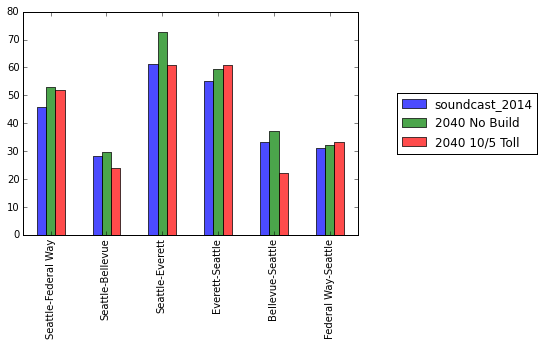

In [206]:
ax = df[[current_run_name,scen1_name,scen2_name]].plot(kind='bar', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel("")